In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Import required modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from zipfile import ZipFile 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() # Interactive mode

In [27]:
# For extracting the zip files

class LoadDataModule(object):
    def __init__(self):
        self.DIR = '/content/drive/MyDrive/Colab Notebooks/DL/CNN/CNN Assignment/'
        pass
    
    # Returns images and labels corresponding for training and testing. Default mode is train. 
    # For retrieving test data pass mode as 'test' in function call.
    def load(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = self.DIR + label_filename + '.zip'
        image_zip = self.DIR + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels


In [28]:
# Create custom dataset

class DressDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels.astype("long")
    self.transform = transform

  def __getitem__(self,idx):
    image =  np.reshape(self.images[idx],(28,28))
    # sample = {'image': image, 'label': labels[idx]}
    # sample = (image,labels[idx])
    # image = ToTensor()
    if self.transform:
      image = self.transform(image)

    return image,self.labels[idx]

  def __len__(self):
    return len(self.images)

In [29]:
# Retriving and splitting data

data_module = LoadDataModule()

train_images, train_labels = data_module.load("train") # 60,000 images - (28,28) flattened to 784 - value (0, 255)
test_images, test_labels = data_module.load("test")    # 10,000 images - (28,28) flattened to 784 - value (0, 255)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2)

training_dataset = DressDataset(X_train,y_train, transform=ToTensor())
validation_dataset = DressDataset(X_val, y_val, transform=ToTensor())
test_dataset = DressDataset(test_images, test_labels, transform=ToTensor())

print("Training Dataset Count:",len(training_dataset),"\nImage size:",training_dataset[0][0].shape[1:],end="\n\n")
print("Validation Dataset Count:",len(validation_dataset),"\nImage size:",validation_dataset[0][0].shape[1:],end="\n\n")
print("Test Dataset Count:",len(test_dataset),"\nImage size:",test_dataset[0][0].shape[1:],end="\n")

train_loader = DataLoader(training_dataset, batch_size=200)
validation_loader = DataLoader(validation_dataset, batch_size=200)
test_loader = DataLoader(test_dataset,batch_size=200)

Training Dataset Count: 48000 
Image size: torch.Size([28, 28])

Validation Dataset Count: 12000 
Image size: torch.Size([28, 28])

Test Dataset Count: 10000 
Image size: torch.Size([28, 28])


In [30]:
# Create network

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,2,kernel_size=3)
    self.conv2 = nn.Conv2d(2,2,kernel_size=3)
    self.pool = nn.MaxPool2d(2,2)
    self.FC1 = nn.Linear(50,50)
    self.FC2 = nn.Linear(50,10)

  def forward(self,x):
    x = self.pool(F.sigmoid(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.tanh(self.FC1(x))
    x = F.log_softmax(self.FC2(x),dim=-1)

    return x

In [31]:
# Create model and select optimizer, loss function

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()

In [53]:
def train(model, dataloader, optimizer, loss_fn):

  size = len(dataloader.dataset)
  train_losses = []
  train_accuracies = []

  for i, data in enumerate(dataloader):
    inputs, labels = data

    if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    train_losses.append(loss.item())
    train_accuracies.append(accuracy_score(labels, outputs.argmax(1).cpu()))

  avg_loss = sum(train_losses) / len(train_losses)
  avg_accuracy = sum(train_accuracies) / len(train_accuracies)

  return avg_loss, avg_accuracy


def validation(model, dataloader, loss_fn):
  size = len(dataloader.dataset)
  validation_losses = list()
  validation_accuracies = list()

  with torch.no_grad():
    for i, data in enumerate(dataloader):
      inputs, labels = data
      if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()
      
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      accuracy = accuracy_score(labels, outputs.argmax(1))

      validation_losses.append(loss)
      validation_accuracies.append(accuracy)

  validation_avg_loss = sum(validation_losses) / len(validation_losses)
  validation_avg_accuracy = sum(validation_accuracies) / len(validation_accuracies)

  return validation_avg_loss, validation_avg_accuracy

def test(model, dataloader, loss_fn):
    model.eval()
    prediction_classes = []
    predictions = []
    test_losses = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)
            prediction = pred.argmax(1)
            predictions.extend(prediction)
            # prediction_classes.extend([classes[pred_val] for pred_val in prediction])
    return predictions

In [44]:
epoches = 20
train_avg_losses = list()
train_avg_accuracies = list()

val_avg_losses = list()
val_avg_accuracies = list()

for epoch in range(1,epoches+1):
  train_avg_loss, train_avg_accuracy = train(model, train_loader, optimizer, loss_fn)
  val_avg_loss, val_avg_accuracy = validation(model, validation_loader, loss_fn)

  train_avg_losses.append(train_avg_loss)
  train_avg_accuracies.append(train_avg_accuracy)

  val_avg_losses.append(val_avg_loss)
  val_avg_accuracies.append(val_avg_accuracy)

  print("Epoch ",epoch)
  print("Avg. Training loss: ",train_avg_loss)
  print("Avg. Validation loss: ",val_avg_loss.item())
  print("-"*20)
  print("Train accuracy avg. score: ",train_avg_accuracy)
  print("Val. accuracy avg. validation: ",val_avg_accuracy)
  print("="*20)


Epoch  1
Avg. Training loss:  0.5493084032088518
Avg. Validation loss:  0.540633499622345
--------------------
Train accuracy avg. score:  0.79225
Val. accuracy avg. validation:  0.7955833333333334
Epoch  2
Avg. Training loss:  0.5472876361260811
Avg. Validation loss:  0.538756251335144
--------------------
Train accuracy avg. score:  0.7934791666666662
Val. accuracy avg. validation:  0.7960833333333335
Epoch  3
Avg. Training loss:  0.5453104803959529
Avg. Validation loss:  0.5369230508804321
--------------------
Train accuracy avg. score:  0.7944791666666665
Val. accuracy avg. validation:  0.7970833333333336
Epoch  4
Avg. Training loss:  0.5433769904077053
Avg. Validation loss:  0.535132110118866
--------------------
Train accuracy avg. score:  0.7950208333333328
Val. accuracy avg. validation:  0.7973333333333333
Epoch  5
Avg. Training loss:  0.5414844308048486
Avg. Validation loss:  0.5333836078643799
--------------------
Train accuracy avg. score:  0.7959583333333333
Val. accuracy a

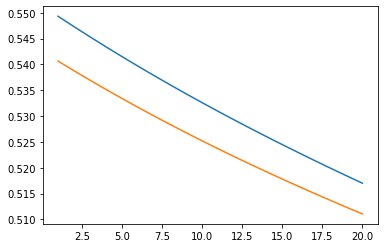

In [45]:
# Model metrics and performance
epochs_range = [i for i in range(1,epoches+1)]
plt.plot(epochs_range, train_avg_losses)
plt.plot(epochs_range, val_avg_losses)
plt.show()

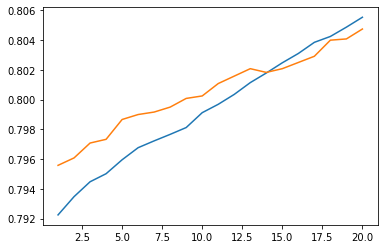

In [46]:
# Accuracy score

epochs_range = [i for i in range(1,epoches+1)]
plt.plot(epochs_range, train_avg_accuracies)
plt.plot(epochs_range, val_avg_accuracies)
plt.show()

In [55]:
# Testing with new dataset

predictions = test(model, test_loader, loss_fn)

for i in range(5):
    print(f"predicted class - actual class: {predictions[i]} - {test_dataset[i][1]}")


print("\n")


accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")


print("\n")


mse = mean_squared_error(test_labels, predictions)
print("Mean squared Error:", mse)


print("\n")


report = classification_report(test_labels, predictions)
print("Classification report:")
print(report)


print("\n")


confusion = confusion_matrix(test_labels, predictions)
print(confusion)


predicted class - actual class: 9 - 9
predicted class - actual class: 2 - 2
predicted class - actual class: 1 - 1
predicted class - actual class: 1 - 1
predicted class - actual class: 2 - 6


Accuracy: 0.7973


Mean squared Error: 2.3731


Classification report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1000
           1       0.95      0.94      0.95      1000
           2       0.57      0.70      0.63      1000
           3       0.80      0.84      0.82      1000
           4       0.59      0.78      0.67      1000
           5       0.94      0.90      0.92      1000
           6       0.63      0.23      0.34      1000
           7       0.90      0.90      0.90      1000
           8       0.93      0.93      0.93      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80